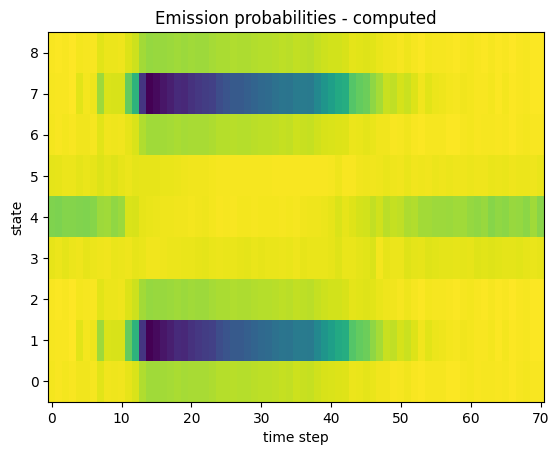

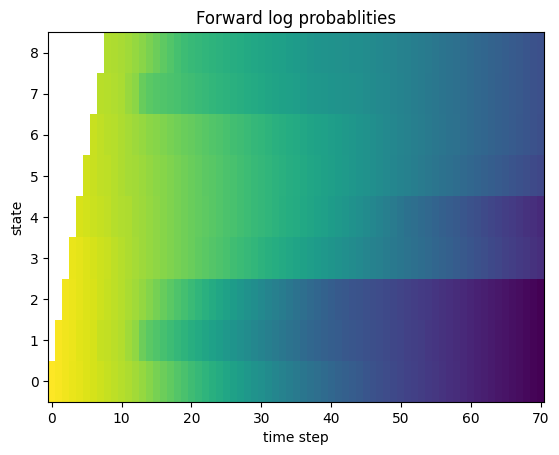

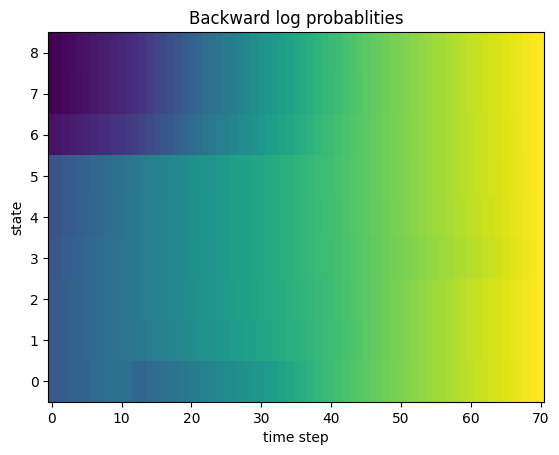

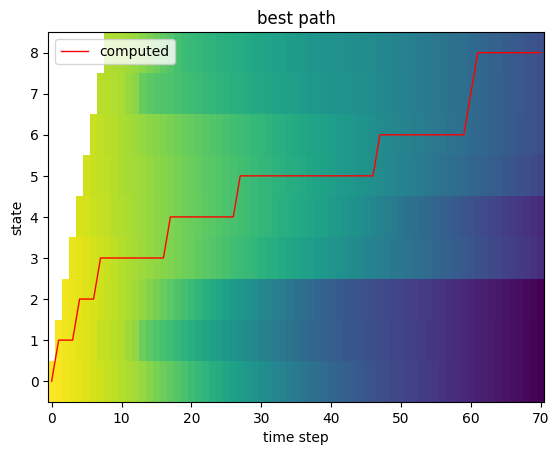

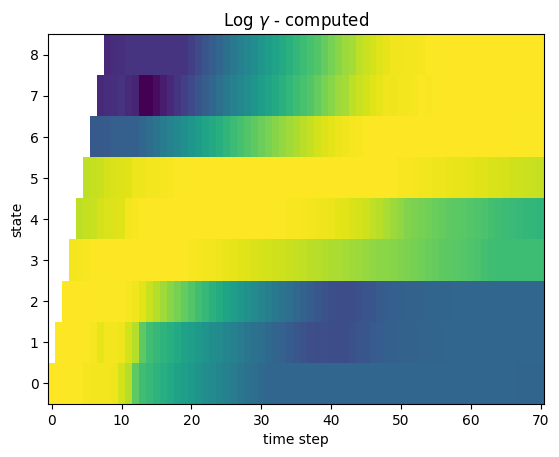

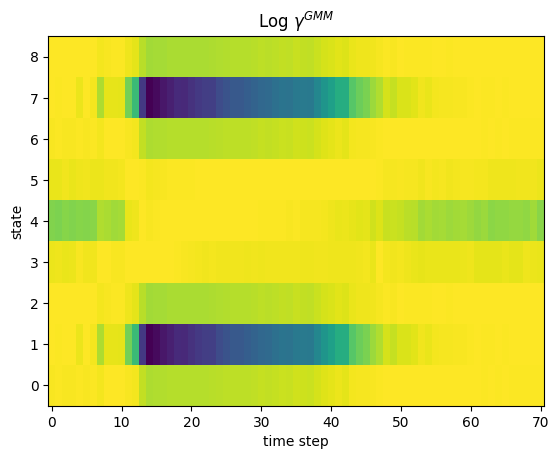

In [2]:
from lab3_proto import *
import numpy as np
from lab3_tools import * 
from lab1_proto import *
from prondict import prondict
from lab2_proto import *
import os
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from tqdm import tqdm

In [3]:
example = np.load('lab3_example.npz', allow_pickle=True)['example'].item()

## 4.1 Target Class Definition

In [5]:
phoneHMMs = np.load('lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [  ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

# # save to file
# state_array = np.array(stateList)
# np.save('state_list.npy', state_array)
# print("State list saved as an npy file.")

stateList = np.load('state_list.npy').tolist()
print(stateList)

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


In [6]:
path2info('tidigits/disc_4.1.1/tidigits/train/woman/ag/1o2a.wav')

('woman', 'ag', '1o2', 'a')

## 4.2 Forced Alignment

In [8]:
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
wordTrans = list(path2info(filename)[2])
phoneTrans = words2phones(wordTrans, prondict)

utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phoneTrans}
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]

obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])

_, vpath = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))

viterbiStateTrans = [stateTrans[state] for state in vpath]
target = [stateList.index(state) for state in viterbiStateTrans]
print(viterbiStateTrans)
print(target)
# frames2trans(viterbiStateTrans, outfilename='z43a.lab')

['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'sp_0', 'f_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil_0', 'sil

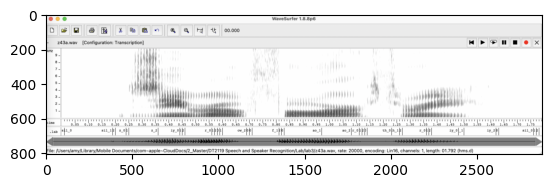

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('z43a.png')
plt.imshow(image)
plt.show()

## 4.3 Feature extraction

In [24]:
traindata = []

for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            samples, samplingrate = loadAudio(filename)
            
            lmfcc = mfcc(samples)
            mspec_res = mspec(samples)
            wordTrans = list(path2info(filename)[2])
            phoneTrans = words2phones(wordTrans, prondict)
            
            viterbiStateTrans = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)

            targets = [stateList.index(state) for state in viterbiStateTrans]
            
            traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspec_res, 'targets': targets})
   
np.savez('traindata.npz', traindata=traindata)
print("finished")

finished


In [10]:
testdata = []

for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            samples, samplingrate = loadAudio(filename)
            
            lmfcc = mfcc(samples)
            mspec_res = mspec(samples)
            wordTrans = list(path2info(filename)[2])
            phoneTrans = words2phones(wordTrans, prondict)
            
            viterbiStateTrans = forcedAlignment(lmfcc, phoneHMMs, phoneTrans)

            targets = [stateList.index(state) for state in viterbiStateTrans]
            
            testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspec_res, 'targets': targets})
   
np.savez('testdata.npz', testdata=testdata)
print("finished")

finished


In [25]:
train_data = np.load('traindata.npz', allow_pickle=True)['traindata']
test_data = np.load('testdata.npz', allow_pickle=True)['testdata']
print(train_data[0]['filename'])

tidigits/disc_4.1.1/tidigits/train/man/pd/1a.wav


## 4.4 Training and Validation Sets
Used **GroupShuffleSplit** from scikit-learn


In [15]:
df = pd.DataFrame(list(train_data))

df['speaker'] = df['filename'].apply(lambda x: x.split('/')[-2])
df['gender'] = df['filename'].apply(lambda x: 'male' if x.split('/')[-3] == 'man' else 'female')

print(df['gender'].value_counts())

print("Unique speakers:", df['speaker'].nunique())
print(df.groupby('gender')['speaker'].nunique())

gender
female    4388
male      4235
Name: count, dtype: int64
Unique speakers: 112
gender
female    57
male      55
Name: speaker, dtype: int64


In [19]:
splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in splitter.split(df, groups=df['speaker']):
      train_set = df.iloc[train_idx]
      val_set = df.iloc[val_idx]

In [20]:
gender_counts_train = train_set['gender'].value_counts(normalize=True)
gender_counts_val = val_set['gender'].value_counts(normalize=True)

print("Gender distribution in training set:\n", gender_counts_train)

Gender distribution in training set:
 gender
female    0.509936
male      0.490064
Name: proportion, dtype: float64


In [21]:
print("Gender distribution in validation set:\n", gender_counts_val)

Gender distribution in validation set:
 gender
male      0.5
female    0.5
Name: proportion, dtype: float64


In [22]:
train_speakers = set(train_set['speaker'])
val_speakers = set(val_set['speaker'])
   
common_speakers = train_speakers.intersection(val_speakers)

print(len(common_speakers) == 0)

True


## 4.5 Acoustic Context 

In [23]:
split_train_set = get_data_from_df(train_set)
split_val_set = get_data_from_df(val_set)
print(f'Calculating "4.5 Acoustic Context"')
train_data = calc_dyn_feat(split_train_set)
val_data = calc_dyn_feat(split_val_set)
test_data = calc_dyn_feat(test_data)

NameError: name 'get_data_from_df' is not defined

In [17]:
print(train_data[0]['lmfcc'])

[[  43.01650777 -141.25202819   59.60007995 ...  128.11223863
   104.41445571  135.43272141]
 [  13.35679752 -182.19497652    2.69465077 ...   53.47767919
    16.39576109   55.70580523]
 [  71.19330241 -188.39082508  -26.02490997 ...  -10.81831071
   -87.38847232   58.53901174]
 ...
 [  76.91332334 -181.0738616  -107.38937949 ...  -51.51982279
   -89.71896586  119.36797839]
 [  38.76448285 -183.14092644  -88.5167919  ...  -44.35797218
    20.44035802  -35.17777398]
 [  13.70040257 -182.69825164    4.14492783 ...  153.46294155
   174.55826143  115.67309518]]


In [18]:
print(train_data[0]['dyn_lmfcc'])

[[  51.86624958 -149.57774174   16.88784928 ... -125.50088931
   -84.09579919   91.44157998]
 [  71.19330241 -188.39082508  -26.02490997 ...  -33.02807482
   -53.78218411  -42.02119993]
 [  13.35679752 -182.19497652    2.69465077 ...   48.46458354
    45.84660952   79.65344777]
 ...
 [  78.65757636 -166.24403731  -23.87955165 ...  -44.35797218
    20.44035802  -35.17777398]
 [  21.51479962 -167.53364535   35.88657157 ...  -51.51982279
   -89.71896586  119.36797839]
 [ 242.92961147 -275.97713136 -362.31129944 ...  180.60280036
    24.7224772   205.93612647]]


## 4.6 Normolization
Normalized over **each speaker seperately**

In [19]:
print(f'Calculating "4.6 normalization"')
normalized_train_data = calc_normalization(train_data)
normalized_val_data = calc_normalization(val_data)
normalized_test_data = calc_normalization(test_data)

Calculating "4.6 normalization"


100%|██████████| 8700/8700 [00:09<00:00, 887.92it/s]


In [ ]:
# save data for training 
prepare_data(normalized_train_data, 'prepared_train_data.npz')
prepare_data(normalized_val_data, 'prepared_val_data.npz')
prepare_data(normalized_test_data, 'prepared_test_data.npz')